In [1]:
import numpy as np 
import pandas as pd
from pandas import datetime
from datetime import datetime
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline    

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error as MSE
from tabulate import tabulate



import warnings
warnings.filterwarnings("ignore")#忽略警告提醒


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
#from statsmodels.tsa.stattools import acf
#random_walk_acf = acf(df)
#acf_plot = plot_acf(random_walk_acf, lags=20)

Step1:
先圖示化資料的樣貌，並且繪製出資料的自相關與偏自相關圖，從自相關的圖可以看到自相關的情形相當明顯，除此之外也利用單跟檢定，利用ADF檢定單跟的方式，檢定結果發現pvalue高達0.85，大於顯著水準，不拒絕虛無假設，圖視覺化相關係數與單跟檢定結果可以知道此資料為非定態。

p-value: 0.9902


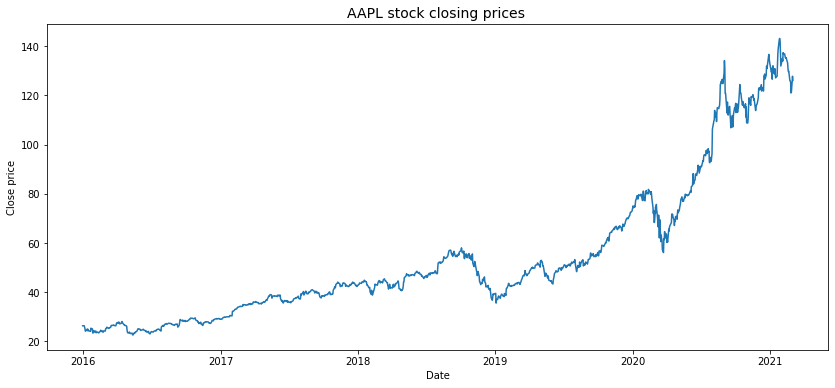

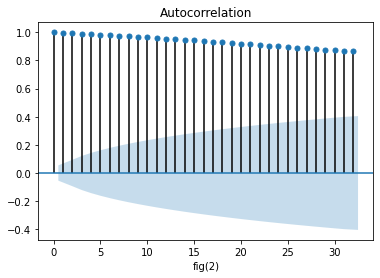

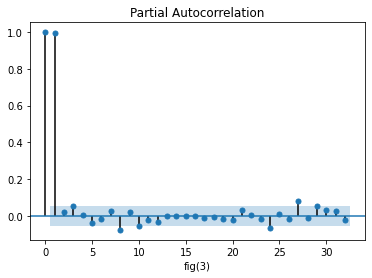

In [3]:
def read_data( ) :
    df = DataReader('AAPL', data_source='yahoo', start='2016-01-01', end=datetime.now()).drop(
    ['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)#從雅虎finance抓取資料
    df.head()
    df.index = pd.to_datetime(df.index)
    plt.figure(figsize = (14,6)) 
    plt.title('AAPL stock closing prices ', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.plot(df['Close'] )


    plot_acf(df)
    plt.xlabel('fig(2)')
    
    plot_pacf(df)
    plt.xlabel('fig(3)')
    
    result = adfuller(df['Close'])
    print('p-value: {}'.format(round(result[1],4)))
    return df
df = read_data()

Step2:
此非定態資料利用一階差分的方式將資料轉為定態，並繪製其自相關係數與偏自相關係數圖，再利用ADF檢定單跟是否存在，可得到pvalue小於0.05，且非常接近零，拒絕虛無假設，解決了單跟的問題。

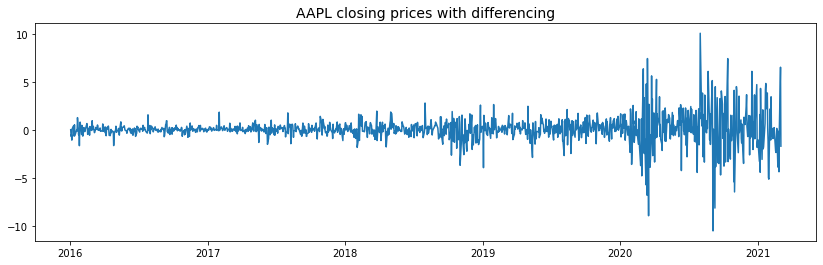

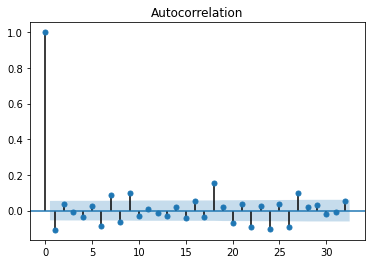

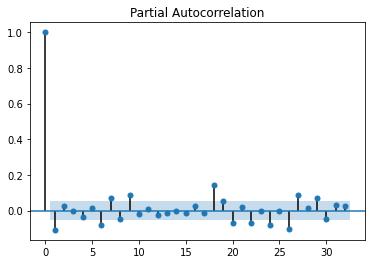

p-value: 0.000000


In [4]:
def test_stational(df):
    
    df_diff = df.diff(periods=1).dropna()# 為了使數據平整，進行一階插方調整，並且進行檢定
#    adf_data = ADF(df_diff)
    plt.figure(figsize = (14,4))
    plt.title("AAPL closing prices with differencing",fontsize=14)
    plt.plot(df_diff)
    
    plot_acf(df_diff)
    plot_pacf(df_diff)
    plt.show()
    
    result = adfuller(df_diff['Close'])
    print('p-value: %f' % result[1])
    return df
df_diff = test_stational(df)

Step3:
由資料型態可以推論出此為ARIMA(1,1,1）模型，但為了盡可能使AIC最小，所以設迴圈來計算當p與q為何時AIC最小，ｐ的範圍設定為1-3，q的範圍設定為1-3，得出結果(p,q)=(1,1)得出ARIMA參數。

In [5]:
Order = []
for p in range(1,3):
    for q in range(1,3):
        try:
            model = ARIMA(df_diff, order=(p, 1, q))
            results = model.fit(disp=0)
            Order.append(round(pd.read_html(results.summary().as_html(), header=0, index_col=0)[0].iloc[2,2],2))
        except:
            Order.append('NA')
            print('No Result')

b = [Order[i:i+2] for i in range(0,len(Order),2)]
Order_df = pd.DataFrame(b,index=range(1,3),columns=range(1,3))
Order_df.index.name = "p \\ q "
print(tabulate(Order_df, headers='keys', tablefmt='fancy_grid',numalign="center"))


╒══════════╤═════════╤═════════╕
│  p \ q   │    1    │    2    │
╞══════════╪═════════╪═════════╡
│    1     │ 4495.19 │ 4496.99 │
├──────────┼─────────┼─────────┤
│    2     │ 4497.05 │ 4499.13 │
╘══════════╧═════════╧═════════╛


Step4:首先來看看配適模型後的統計結果，先將資料的80%最為訓練集、20%作為測試集。而當我們預測完一天後，將會把當天實際真實的股價加進訓練資料，再進行隔一天的預測作，如此不斷重複。

In [6]:
price = df_diff.values
length = int(len(price) * 0.8)
train = list(price[0:length])
test =  price[length:len(price)]
df_diff = df_diff.index[length:len(price)]
predictions = []

for i in range(len(test)):
    model = ARIMA(train, order=(2, 1, 2))
    model_fit = model.fit(disp=0)
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    real = test[i]
    train.append(real[0])   
#如果要製作上下界：    low_bound.append(model_fit.forecast()[2][0][0])
#    up_bound.append(model_fit.forecast()[2][0][1])

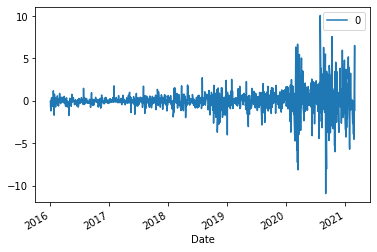

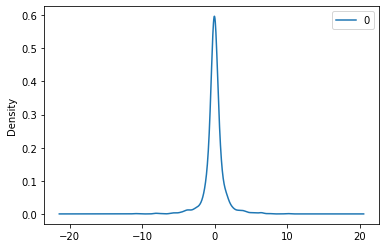

In [7]:
#觀察殘差機率分佈圖，發現殘差有符合平穩，且符合正態分佈
residuals = pd.DataFrame(results.resid)
residuals.plot()


residuals.plot(kind='kde')



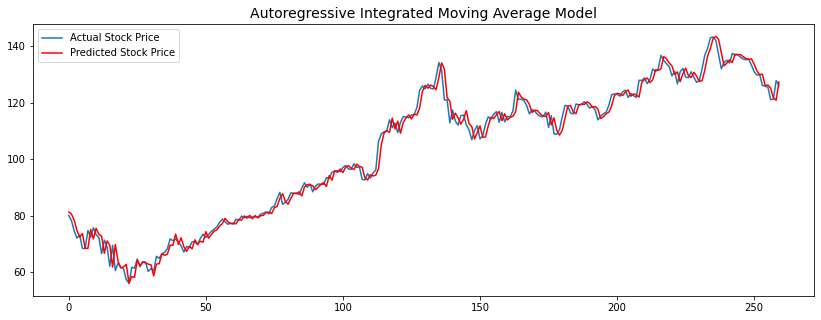

In [8]:
#圖示結果，顯示預測歷史數據的狀況
#up=pd.DataFrame(up_bound)
#low=pd.DataFrame(low_bound)
plt.figure(figsize = (14,5))
plt.title("Autoregressive Integrated Moving Average Model",fontsize=14)
#plt.plot(up, label='up_bound',color='yellow')
#plt.plot(low, label='low_bound',color='yellow')
plt.plot(test, label = 'Actual Stock Price')
plt.plot(predictions, color = 'r', label = 'Predicted Stock Price')
plt.legend()

In [9]:
#計算MSE
MSE = MSE(test, predictions)
print('Mean Squared Error : '+str(round(MSE,4)))

Mean Squared Error : 7.7288


In [29]:
predictions1 = pd.DataFrame(predictions)

In [27]:
predictions1 = predictions.values

AttributeError: 'list' object has no attribute 'values'

In [30]:
from sklearn.metrics import roc_auc_score
#y_hat = xgb.predict(x)
score = roc_auc_score(test1, predictions)
print("Overall AUC: {:.3f}" .format(score))

ValueError: continuous format is not supported

In [31]:
start

1554

In [32]:
end

1734

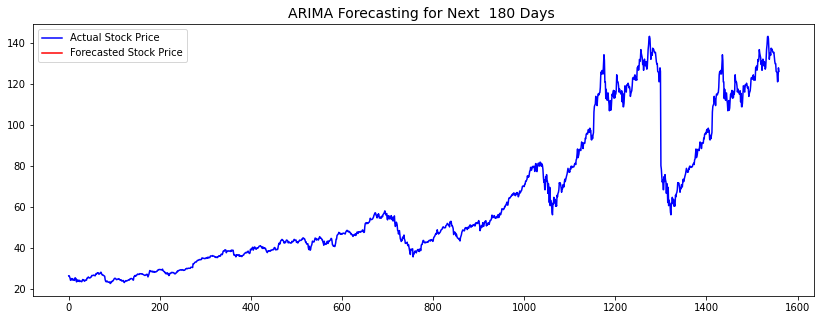

In [11]:
#對於未來半年的走勢進行預測，由圖可得知未來半年股價走升的機率很高
test1 = test.flatten()
forcat=180
start = len(train) + len(test1)
end = len(train) + len(test1) + int(forcat)

train_test = np.concatenate((train, test1))
stock_history = [x for x in train_test]
history = pd.Series(stock_history)

plt.figure(figsize = (14,5))
plt.title("ARIMA Forecasting for Next  180 Days ",fontsize=14)
plt.plot(history[0:start], color = 'b' ,label = 'Actual Stock Price')
plt.plot(history[start:end], color = 'r', label='Forecasted Stock Price')
plt.legend()

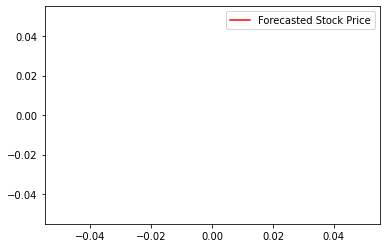

In [12]:
plt.plot(history[start:end], color = 'r', label='Forecasted Stock Price')
plt.legend()

可以看到預測和實際的股價走勢很雷同，那是因為我們每一天都會加入前一天的最新(正確)資料，而前一天的資料對預測的影響最為明顯，所以預測走勢的變化通常會和一天的價格變化雷同。 

In [9]:
#對於未來半年的走勢進行預測，由圖可得知未來半年股價走升的機率很高
start = len(train) + len(test)
end = len(train) + len(test) + int(180)

train_test = np.concatenate((train, test))
stock_history = [x for x in train_test]
history = pd.Series(stock_history)

plt.figure(figsize = (14,5))
plt.title("ARIMA Forecasting for Next  180 Days ",fontsize=14)
plt.plot(history[0:start], label = 'Actual Stock Price')
plt.plot(history[start:end], color = 'r', label='Forecasted Stock Price')
plt.legend()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

NameError: name 'up' is not defined

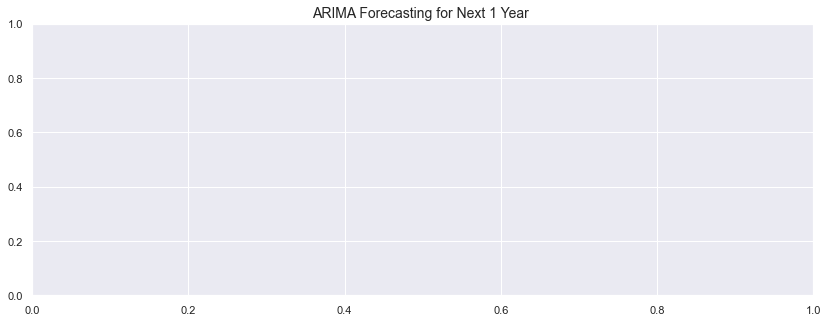

In [12]:
up=pd.DataFrame(up_)

plt.figure(figsize=(14,5))
plt.title("ARIMA Forecasting for Next 1 Year ",fontsize=14)
plt.plot(up,color='red')
plt.plot(low,color='red')
plt.plot(test,color='yellow')
plt.plot(predictions,color='blue')

In [25]:
forecasting_days=100
start = len(test)
end = len(test) + int(forecasting_days)
history = pd.Series(df)

plt.figure(figsize=(14,5))
plt.title("ARIMA Forecasting for Next 300 Days",fontsize=14)
plt.plot(history[0:start], label='Actual Stock Price')
plt.plot(history[start:end], color='r', label='Forecasted Stock Price')
plt.legend()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
'''
pred_vals = model_fit.predict('20170102', '20170301',
                                     dynamic=True, typ='levels')
print(pred_vals)

    # 6. 可视化预测结果
stock_forcast = pd.concat([stock_s, pred_vals], axis=1, keys=['original', 'predicted'])

plt.figure()
plt.plot(stock_forcast)
plt.title('真实值vs预测值')
'''

In [ ]:
predictions_p_ms = model_fit.predict(start=len(df), end=len(df)+len(test)-1)
predictions_f_ms = model_fit.forecast(steps=len(test))[0]

In [12]:
predictions_p_ms = model_fit.predict(start=len(df), end=len(df)+len(test)-1)

In [13]:
predictions_f_ms = model_fit.forecast(steps=len(test))[0]

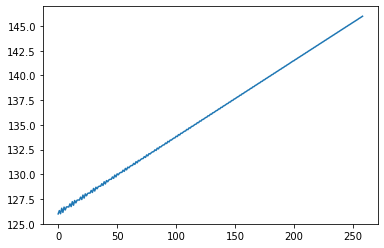

In [14]:
plt.plot(predictions_f_ms)

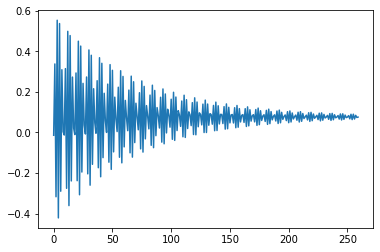

In [15]:
plt.plot(predictions_p_ms)

In [16]:
pred_vals = model_fit.predict('2020/01/02', '2020/03/01',
                                     dynamic=True, typ='levels')
print(pred_vals)

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

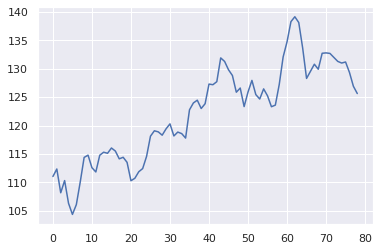

In [16]:
plt.plot(low_bound)


In [ ]:
#######

In [17]:
stock_history = [x for x in train ]
preds = []

# order=(p,d,q)
p = 5   # AR parameters/Lags
q = 1    # Differencing order
d = 0    # MA parameters

#arima_model = ARIMA(train, order=(5,1,0))
#arima_model_fit = arima_model.fit()

for i in range(len(test)):
    # initiate ARIMA model
    arima_model = ARIMA(stock_history, order=(p,q,d))
    # fit ARIMA mode;
    arima_model_fit = arima_model.fit()
    # forecast price
    output = arima_model_fit.forecast()[0]
    # append the test price to a stock history data
    stock_history.append(test[i])  
    # append the forcasted price to a list
    preds.append(output)

In [19]:
print("Mean Squared Error : %.2f" % mean_squared_error(test, preds))
plt.figure(figsize=(14,5))
plt.title("Autoregressive Integrated Moving Average Model",fontsize=14)
plt.plot(test, label='Actual Stock Price')
plt.plot(preds, color='r', label='Predicted Stock Price')
plt.legend()

NameError: name 'preds' is not defined

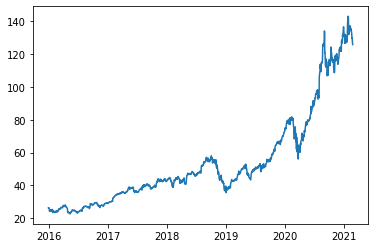

In [38]:
plt.plot(df)

In [36]:
train_test = np.concatenate((train, test1))
stock_history = [x for x in train_test]
preds = []
forecasting_days = 300

for i in range(forecasting_days):
    # initiate ARIMA model
    arima_model = ARIMA(stock_history, order=(2,1,2))
    # fit ARIMA mode;
    arima_model_fit = arima_model.fit()
    # forecast price
    output = arima_model_fit.forecast()[0]
    # append the forecasted price to a stock history data
    stock_history.append(output)  
    # append the forcasted price to a prediction list
    preds.append(output)

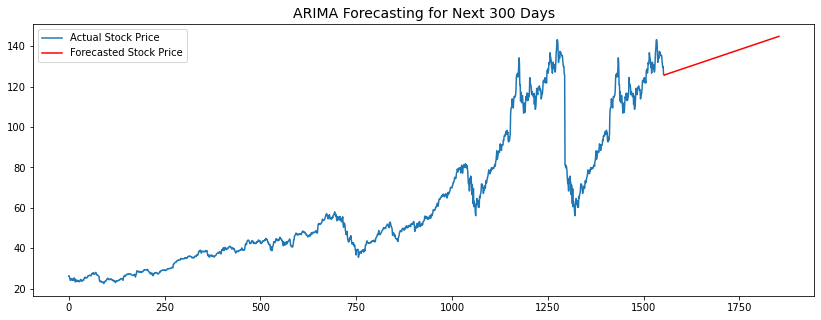

In [37]:
start = len(train_test)
end = len(train_test) + int(forecasting_days)
history = pd.Series(stock_history)

plt.figure(figsize=(14,5))
plt.title("ARIMA Forecasting for Next 300 Days",fontsize=14)
plt.plot(history[0:start], label='Actual Stock Price')
plt.plot(history[start:end], color='r', label='Forecasted Stock Price')
plt.legend()

In [ ]:
####try 

In [35]:
stock_history = [x for x in train ]
preds = []

# order=(p,d,q)
p = 1   # AR parameters/Lags
q = 1    # Differencing order
d = 1    # MA parameters

#arima_model = ARIMA(train, order=(5,1,0))
#arima_model_fit = arima_model.fit()

for i in range(len(test)):
    # initiate ARIMA model
    arima_model = ARIMA(stock_history, order=(p,q,d))
    # fit ARIMA mode;
    arima_model_fit = arima_model.fit()
    # forecast price
    output = arima_model_fit.forecast()[0]
    # append the test price to a stock history data
    stock_history.append(test[i])  
    # append the forcasted price to a list
    preds.append(output)

ValueError: could not convert string to float: 'Close'

Mean Squared Error : 9.21


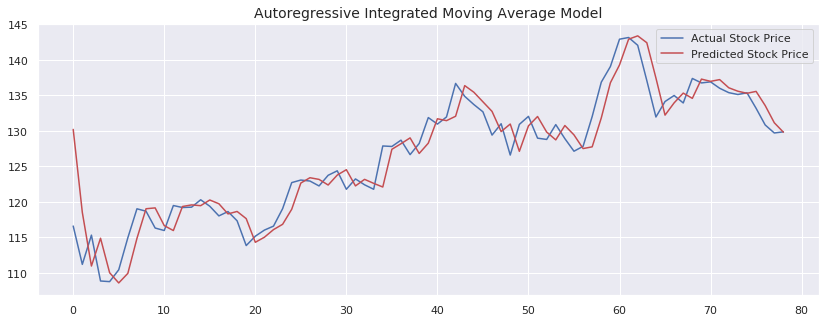

In [30]:
print("Mean Squared Error : %.2f" % mean_squared_error(test, preds))
plt.figure(figsize=(14,5))
plt.title("Autoregressive Integrated Moving Average Model",fontsize=14)
plt.plot(test, label='Actual Stock Price')
plt.plot(preds, color='r', label='Predicted Stock Price')
plt.legend()

In [24]:
train_test = np.concatenate((train, test))
stock_history = [x for x in train_test]
preds = []
forecasting_days = 300

for i in range(forecasting_days):
    # initiate ARIMA model
    arima_model = ARIMA(stock_history, order=(p,q,d))
    # fit ARIMA mode;
    arima_model_fit = arima_model.fit()
    # forecast price
    output = arima_model_fit.forecast()[0]
    # append the forecasted price to a stock history data
    stock_history.append(output)  
    # append the forcasted price to a prediction list
    preds.append(output)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
start = len(train_test)
end = len(train_test) + int(forecasting_days)
history = pd.Series(stock_history)

plt.figure(figsize=(14,5))
plt.title("ARIMA Forecasting for Next 300 Days",fontsize=14)
plt.plot(history[0:start], label='Actual Stock Price')
plt.plot(history[start:end], color='r', label='Forecasted Stock Price')
plt.legend()

In [ ]:
###如何訪不只一張圖

plt.subplot(2,3,3)
plt.title("Student Success for Student Absence Day")
sns.barplot(df["StudentAbsenceDays"],y=df["studentsuccess"], data=df, palette="Greens")
plt.ylabel("Student  Success")
    
plt.subplot(2,3,4)
sns.barplot(x=df["ParentschoolSatisfaction"], y=df["studentsuccess"], data=df, palette="Greens")
plt.xticks(rotation=55)
